## Load metadata

In [61]:
import pandas as pd

metadata_path = '/content/drive/MyDrive/cse151a_groupProject/isic-2024-challenge/train-metadata.csv'
isic_2020_path = '/content/drive/MyDrive/cse151a_groupProject/CSE_151A_Project_Data /ISIC_2020/ISIC2020_Training_labels.csv'
isic_2019_path = '/content/drive/MyDrive/cse151a_groupProject/CSE_151A_Project_Data /ISIC_2019/ISIC2019_Training_labels.csv'
isic_2018_path = '/content/drive/MyDrive/cse151a_groupProject/CSE_151A_Project_Data /ISIC_2018/ISIC2018_Training_labels.csv'
isic_2017_path = '/content/drive/MyDrive/cse151a_groupProject/CSE_151A_Project_Data /ISIC_2017/ISIC2017_Training_labels.csv'
isic_2016_path = '/content/drive/MyDrive/cse151a_groupProject/CSE_151A_Project_Data /ISIC_2016/ISBI2016_Training_labels.csv'

metadata = pd.read_csv(metadata_path)
isic_2020 = pd.read_csv(isic_2020_path)
isic_2019 = pd.read_csv(isic_2019_path)
isic_2018 = pd.read_csv(isic_2018_path)
isic_2017 = pd.read_csv(isic_2017_path)
isic_2016 = pd.read_csv(isic_2016_path)

isic_2020 = isic_2020[['image_name', 'target']]
isic_2020.rename(columns={'image_name': 'isic_id'}, inplace=True)

isic_2019 = isic_2019[['image', 'MEL']]
isic_2019.rename(columns={'image': 'isic_id', 'MEL': 'target'}, inplace=True)

isic_2018 = isic_2018[['image', 'MEL']]
isic_2018.rename(columns={'image': 'isic_id', 'MEL': 'target'}, inplace=True)

isic_2017 = isic_2017[['image_id', 'melanoma']]
isic_2017.rename(columns={'image_id': 'isic_id', 'melanoma': 'target'}, inplace=True)

isic_2016.columns = ['isic_id', 'target']
isic_2016['target'] = isic_2016['target'].map({'malignant': 1, 'benign': 0})

metadata = pd.concat([metadata, isic_2020, isic_2019, isic_2018, isic_2017, isic_2016], ignore_index=True)
metadata = metadata[['isic_id', 'tbp_lv_color_std_mean', 'age_approx', 'target']]

combined_metadata = pd.concat([metadata, isic_2020, isic_2019, isic_2018, isic_2017, isic_2016], ignore_index=True)

combined_metadata['tbp_lv_color_std_mean'].fillna(combined_metadata['tbp_lv_color_std_mean'].mean(), inplace=True)
combined_metadata['age_approx'].fillna(combined_metadata['age_approx'].mean(), inplace=True)


<ipython-input-61-18cdfc749c91>:10: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_path)


In [62]:
if 'tbp_lv_color_std_mean' in metadata.columns:
    print("Column 'tbp_lv_color_std_mean' found")
else:
    print("Column 'tbp_lv_color_std_mean' not found")

metadata['tbp_lv_color_std_mean'].fillna(metadata['tbp_lv_color_std_mean'].mean(), inplace=True)
metadata['age_approx'].fillna(metadata['age_approx'].mean(), inplace=True)

Column 'tbp_lv_color_std_mean' found


In [63]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.special import expit

X = combined_metadata['tbp_lv_color_std_mean'].values.reshape(-1, 1)
y = combined_metadata['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

model = LinearRegression()
model.fit(X_poly_train, y_train)

y_train_pred = model.predict(X_poly_train)
y_test_pred = model.predict(X_poly_test)

y_train_pred_sigmoid = expit(y_train_pred)
y_test_pred_sigmoid = expit(y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred_sigmoid)
test_mse = mean_squared_error(y_test, y_test_pred_sigmoid)

train_r2 = r2_score(y_train, y_train_pred_sigmoid)
test_r2 = r2_score(y_test, y_test_pred_sigmoid)


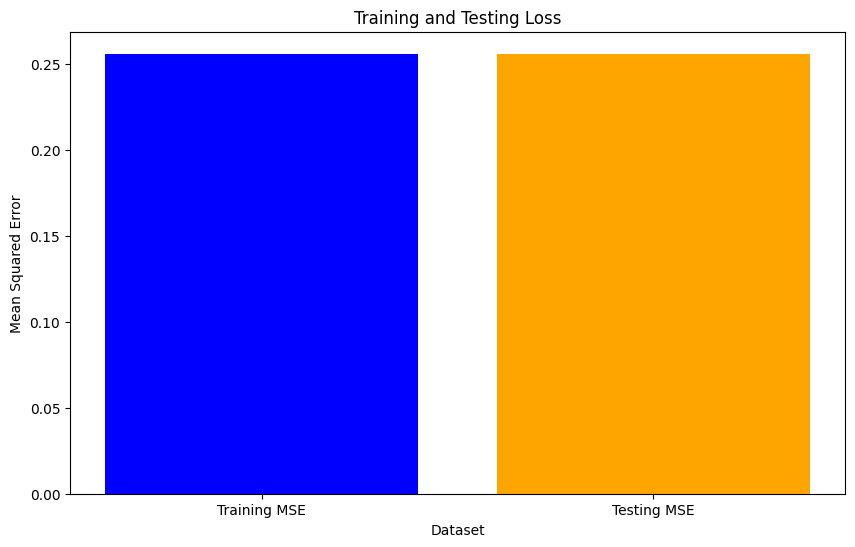

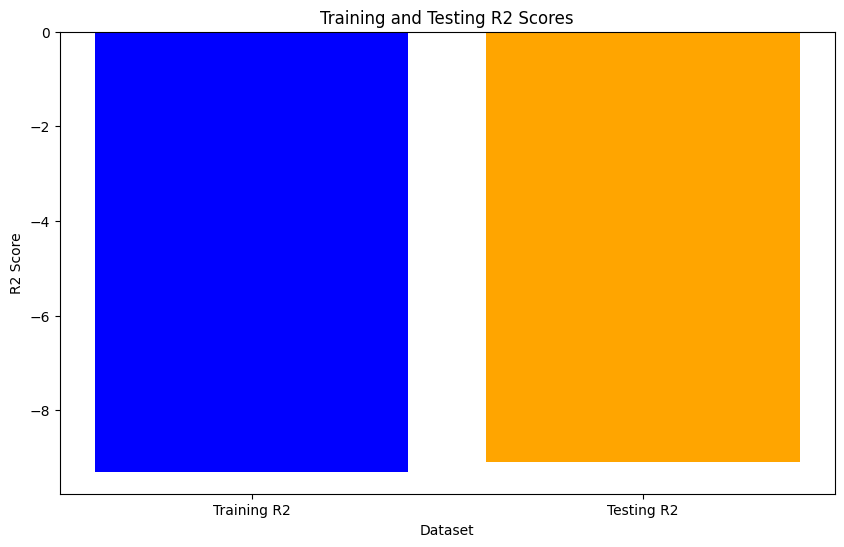

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


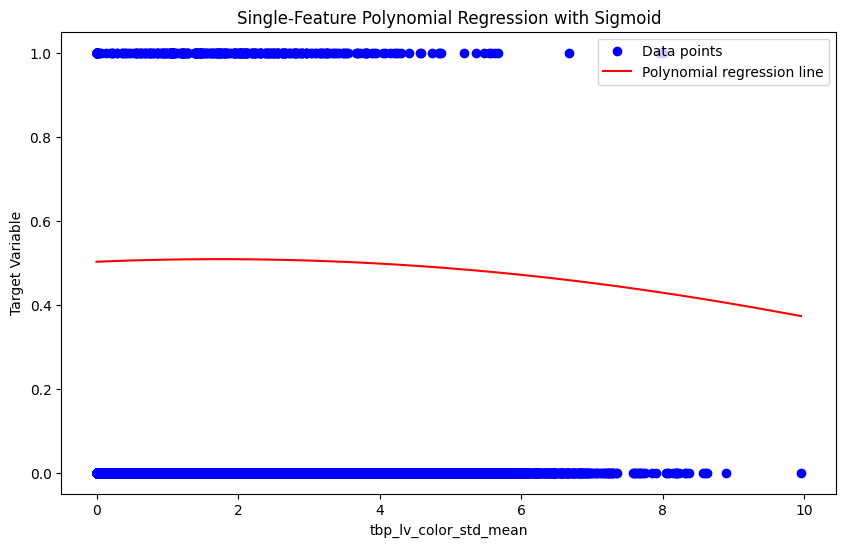

Training MSE: 0.25605613505941743
Testing MSE: 0.256037064192192
Training R2: -9.302834943341267
Testing R2: -9.102752537269108


In [64]:
plt.figure(figsize=(10, 6))
plt.bar(['Training MSE', 'Testing MSE'], [train_mse, test_mse], color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(['Training R2', 'Testing R2'], [train_r2, test_r2], color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('R2 Score')
plt.title('Training and Testing R2 Scores')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data points')
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_range_poly = poly.transform(X_range)
y_range_pred = model.predict(X_range_poly)
y_range_pred_sigmoid = expit(y_range_pred)
plt.plot(X_range, y_range_pred_sigmoid, color='red', label='Polynomial regression line')
plt.xlabel('tbp_lv_color_std_mean')
plt.ylabel('Target Variable')
plt.title('Single-Feature Polynomial Regression with Sigmoid')
plt.legend()
plt.show()

print(f"Training MSE: {train_mse}")
print(f"Testing MSE: {test_mse}")
print(f"Training R2: {train_r2}")
print(f"Testing R2: {test_r2}")


Final Training MSE: 0.024560217756491337
Final Testing MSE: 0.025042293669149448
Final Training R2: 0.01177970346646029
Final Testing R2: 0.011877062786783354


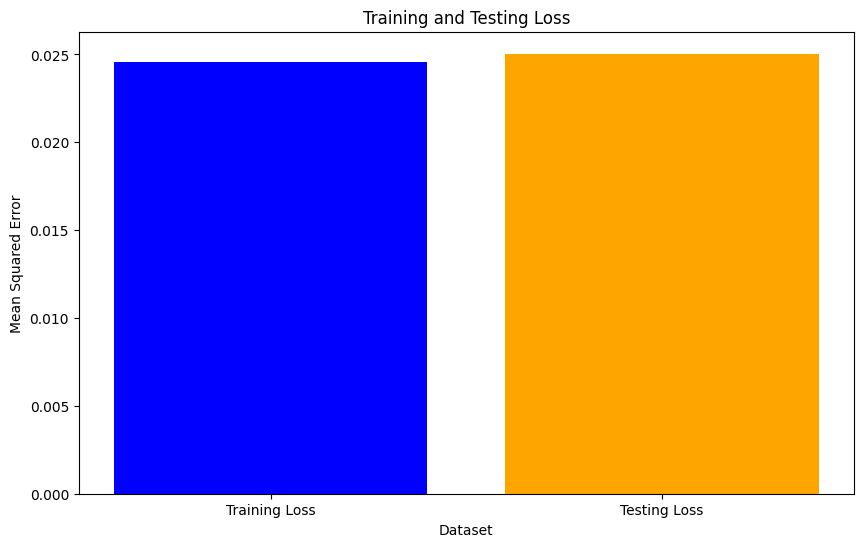

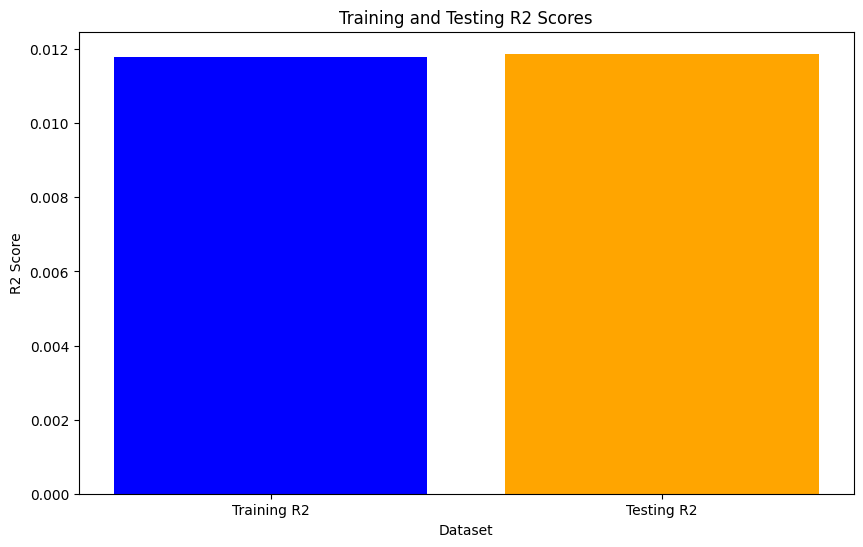

In [65]:
features = ['tbp_lv_color_std_mean', 'age_approx']
target_variable = 'target'

X = combined_metadata[features].values
y = combined_metadata[target_variable].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Final Training MSE: {train_mse}")
print(f"Final Testing MSE: {test_mse}")
print(f"Final Training R2: {train_r2}")
print(f"Final Testing R2: {test_r2}")

plt.figure(figsize=(10, 6))
plt.bar(['Training Loss', 'Testing Loss'], [train_mse, test_mse], color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(['Training R2', 'Testing R2'], [train_r2, test_r2], color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('R2 Score')
plt.title('Training and Testing R2 Scores')
plt.show()


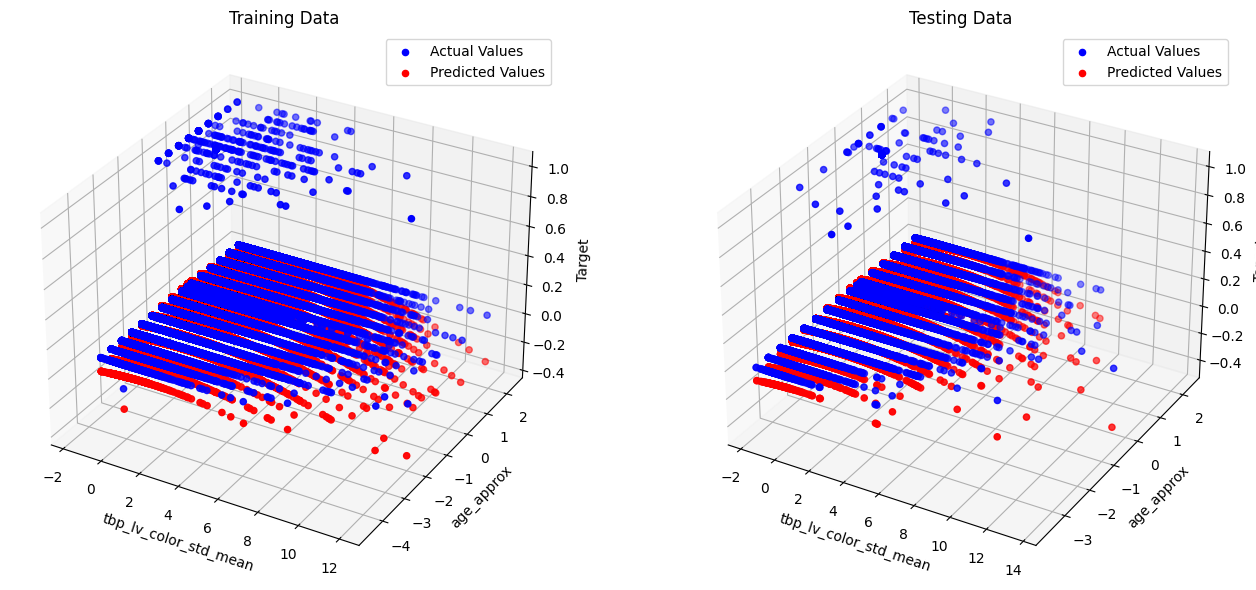

In [66]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], y_train, color='blue', label='Actual Values')
ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], y_train_pred, color='red', label='Predicted Values')
ax.set_title('Training Data')
ax.set_xlabel('tbp_lv_color_std_mean')
ax.set_ylabel('age_approx')
ax.set_zlabel('Target')
ax.legend()

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], y_test, color='blue', label='Actual Values')
ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], y_test_pred, color='red', label='Predicted Values')
ax.set_title('Testing Data')
ax.set_xlabel('tbp_lv_color_std_mean')
ax.set_ylabel('age_approx')
ax.set_zlabel('Target')
ax.legend()

plt.tight_layout()
plt.show()

chatgpt usage:
"do you use multiple features or just one feature for polynomial regression" "how would i make a 3d plot using this code?"
"this is the plot from the polynomial model. interpret it please"